<a href="https://colab.research.google.com/github/rameshavinash94/CMPE258_Assignment4/blob/main/colab_to_Illustrate_use_of_various_activation_functions%2C_dropouts%2C_learning_rate_schedulers_%2C_regularization_techniques_like_gradient_clipping%2C_batch_normalization%2C_early_stopping%2C_l1_and_l2_regularizations%2C_optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Vanishing/Exploding Gradients Problem**

In [3]:
def logit(z):
    return 1 / (1 + np.exp(-z))

Saving figure sigmoid_saturation_plot


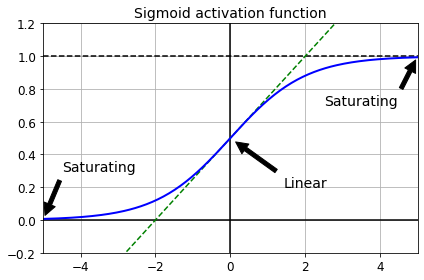

In [4]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("sigmoid_saturation_plot")
plt.show()

**Xavier and He Initialization**

In [5]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [6]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [7]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

**Nonsaturating Activation Functions**

**Leaky ReLU**

In [8]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

Saving figure leaky_relu_plot


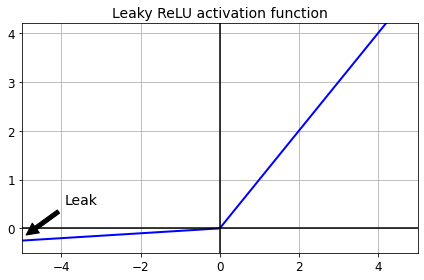

In [9]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

save_fig("leaky_relu_plot")
plt.show()

In [10]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [11]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [12]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [14]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.7955 - accuracy: 0.7361 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5339 - accuracy: 0.8223 - val_loss: 0.5156 - val_accur

**PRELU**

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [18]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6966 - accuracy: 0.7694 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8046
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5618 - accuracy: 0.8134 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accura

**ELU**

In [19]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

Saving figure elu_plot


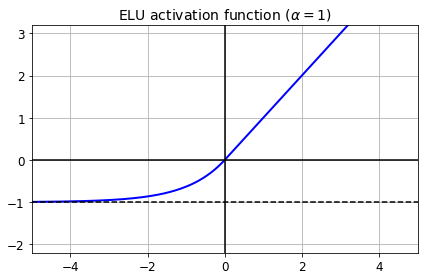

In [20]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("elu_plot")
plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [21]:
keras.layers.Dense(10, activation="elu")

**SELU**

In [22]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [23]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

Saving figure selu_plot


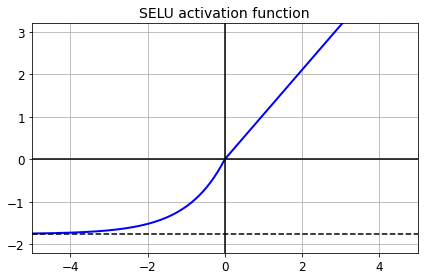

In [24]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

save_fig("selu_plot")
plt.show()

In [25]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [26]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [29]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [30]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [31]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 38s 20ms/step - loss: 1.3776 - accuracy: 0.4540 - val_loss: 1.1731 - val_accuracy: 0.5614
Epoch 2/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.9138 - accuracy: 0.6665 - val_loss: 0.7028 - val_accuracy: 0.7484
Epoch 3/5
1719/1719 [==============================] - 34s 20ms/step - loss: 0.6962 - accuracy: 0.7481 - val_loss: 0.6540 - val_accuracy: 0.7546
Epoch 4/5
1719/1719 [==============================] - 35s 20ms/step - loss: 0.6539 - accuracy: 0.7676 - val_loss: 0.5557 - val_accuracy: 0.7978
Epoch 5/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.5582 - accuracy: 0.7990 - val_loss: 0.5703 - val_accuracy: 0.8016


Now look at what happens if we try to use the ReLU activation function instead:

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [34]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [35]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 38s 20ms/step - loss: 1.8261 - accuracy: 0.2616 - val_loss: 1.3347 - val_accuracy: 0.3894
Epoch 2/5
1719/1719 [==============================] - 33s 19ms/step - loss: 1.1959 - accuracy: 0.4908 - val_loss: 0.9373 - val_accuracy: 0.5902
Epoch 3/5
1719/1719 [==============================] - 31s 18ms/step - loss: 0.9600 - accuracy: 0.6118 - val_loss: 0.9026 - val_accuracy: 0.5906
Epoch 4/5
1719/1719 [==============================] - 31s 18ms/step - loss: 0.8231 - accuracy: 0.6759 - val_loss: 0.7320 - val_accuracy: 0.7290
Epoch 5/5
1719/1719 [==============================] - 31s 18ms/step - loss: 0.7360 - accuracy: 0.7171 - val_loss: 0.7823 - val_accuracy: 0.7108


Not great at all, we suffered from the vanishing/exploding gradients problem.

**Batch Normalization**

In [36]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [38]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [39]:
#bn1.updates #deprecated

In [40]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [41]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8750 - accuracy: 0.7123 - val_loss: 0.5525 - val_accuracy: 0.8224
Epoch 2/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5754 - accuracy: 0.8030 - val_loss: 0.4725 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5189 - accuracy: 0.8205 - val_loss: 0.4376 - val_accuracy: 0.8550
Epoch 4/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4827 - accuracy: 0.8324 - val_loss: 0.4153 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4565 - accuracy: 0.8407 - val_loss: 0.3997 - val_accuracy: 0.8644
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4397 - accuracy: 0.8475 - val_loss: 0.3867 - val_accuracy: 0.8694
Epoch 7/10
1719/1719 [==============================] - 13s 7ms/step - loss: 0.4241 - accuracy: 0.8515 - val_loss: 0.3762 - val_ac

In [42]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [43]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [44]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 15s 8ms/step - loss: 1.0317 - accuracy: 0.6756 - val_loss: 0.6767 - val_accuracy: 0.7814
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6790 - accuracy: 0.7793 - val_loss: 0.5566 - val_accuracy: 0.8184
Epoch 3/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.5960 - accuracy: 0.8037 - val_loss: 0.5007 - val_accuracy: 0.8362
Epoch 4/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5447 - accuracy: 0.8191 - val_loss: 0.4666 - val_accuracy: 0.8452
Epoch 5/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5109 - accuracy: 0.8280 - val_loss: 0.4434 - val_accuracy: 0.8536
Epoch 6/10
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4898 - accuracy: 0.8337 - val_loss: 0.4263 - val_accuracy: 0.8548
Epoch 7/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4712 - accuracy: 0.8396 - val_loss: 0.4130 - val_ac

**Gradient Clipping**

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [45]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [46]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

**Optimizers**

**Momentum optimization**

In [47]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

**Nesterov Accelerated Gradient**

In [48]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

**AdaGrad**

In [49]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

**RMSProp**

In [50]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

**Adam Optimization**

In [51]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

**Adamax Optimization**

In [52]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

**Nadam Optimization**

In [53]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

**Learning Rate Scheduling**

**Power Scheduling**

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [54]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [55]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [56]:
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4904 - accuracy: 0.8269 - val_loss: 0.4097 - val_accuracy: 0.8586
Epoch 2/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3821 - accuracy: 0.8659 - val_loss: 0.3779 - val_accuracy: 0.8694
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3498 - accuracy: 0.8757 - val_loss: 0.3806 - val_accuracy: 0.8692
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3292 - accuracy: 0.8827 - val_loss: 0.3563 - val_accuracy: 0.8780
Epoch 5/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3139 - accuracy: 0.8883 - val_loss: 0.3496 - val_accuracy: 0.8786
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3002 - accuracy: 0.8932 - val_loss: 0.3478 - val_accuracy: 0.8794
Epoch 7/25
1719/1719 [==============================] - 10s 6ms/step - loss: 0.2904 - accuracy: 0.8970 - val_loss: 0.3430 - val_accuracy

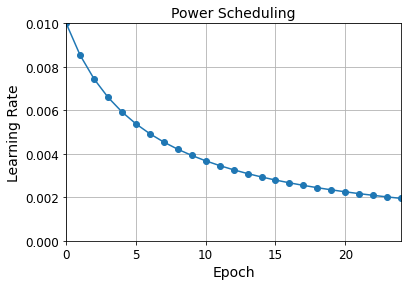

In [57]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**Exponential Scheduling**

```lr = lr0 * 0.1**(epoch / s)```

In [58]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [59]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [60]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [61]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 15s 8ms/step - loss: 0.8517 - accuracy: 0.7559 - val_loss: 0.9075 - val_accuracy: 0.7320 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7787 - accuracy: 0.7687 - val_loss: 0.8379 - val_accuracy: 0.8070 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6808 - accuracy: 0.7917 - val_loss: 0.7336 - val_accuracy: 0.7832 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5639 - accuracy: 0.8288 - val_loss: 0.5345 - val_accuracy: 0.8432 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.5325 - accuracy: 0.8385 - val_loss: 0.5295 - val_accuracy: 0.8448 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4622 - accuracy: 0.8571 - val_loss: 0.4782 - val_accuracy: 0.8594 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================

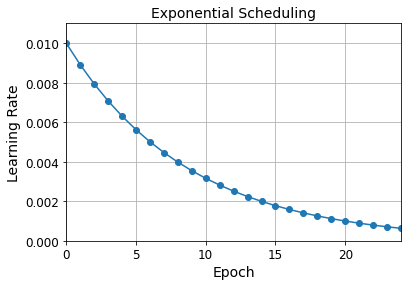

In [62]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [63]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [64]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.learning_rate)
        K.set_value(self.model.optimizer.learning_rate, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.learning_rate)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.7965 - accuracy: 0.7648 - val_loss: 0.6834 - val_accuracy: 0.8020 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 17s 10ms/step - loss: 0.6950 - accuracy: 0.7953 - val_loss: 0.5449 - val_accuracy: 0.8384 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.6285 - accuracy: 0.8143 - val_loss: 0.9357 - val_accuracy: 0.7404 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5670 - accuracy: 0.8268 - val_loss: 0.6008 - val_accuracy: 0.8392 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5165 - accuracy: 0.8442 - val_loss: 0.5465 - val_accuracy: 0.8530 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4839 - accuracy: 0.8508 - val_loss: 0.4905 - val_accuracy: 0.8562 - lr: 0.0050
Epoch 7/25
1719/1719 [============================

In [65]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

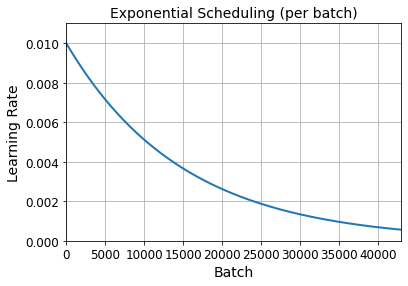

In [66]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

**Piecewise Constant Scheduling**

In [67]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [68]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [69]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 15s 8ms/step - loss: 0.8286 - accuracy: 0.7623 - val_loss: 0.9734 - val_accuracy: 0.7128 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8418 - accuracy: 0.7533 - val_loss: 0.8721 - val_accuracy: 0.7604 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8128 - accuracy: 0.7693 - val_loss: 1.2051 - val_accuracy: 0.6322 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.8872 - accuracy: 0.7563 - val_loss: 0.9807 - val_accuracy: 0.7426 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7762 - accuracy: 0.7832 - val_loss: 1.0048 - val_accuracy: 0.7440 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 15s 9ms/step - loss: 0.5127 - accuracy: 0.8471 - val_loss: 0.5807 - val_accuracy: 0.8572 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================

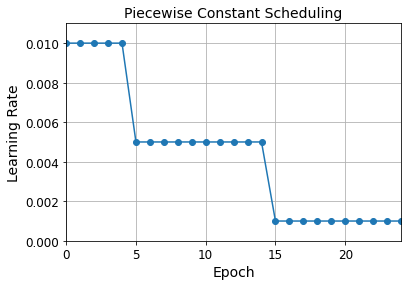

In [70]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

**Performance Scheduling**

In [71]:
tf.random.set_seed(42)
np.random.seed(42)

In [72]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 10s 5ms/step - loss: 0.5908 - accuracy: 0.8070 - val_loss: 0.4863 - val_accuracy: 0.8474 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4939 - accuracy: 0.8393 - val_loss: 0.6034 - val_accuracy: 0.8374 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5016 - accuracy: 0.8439 - val_loss: 0.4986 - val_accuracy: 0.8544 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5030 - accuracy: 0.8486 - val_loss: 0.5206 - val_accuracy: 0.8588 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5136 - accuracy: 0.8504 - val_loss: 0.4708 - val_accuracy: 0.8560 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.5028 - accuracy: 0.8559 - val_loss: 0.5840 - val_accuracy: 0.8518 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 8

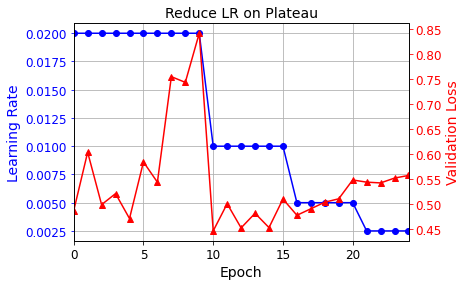

In [73]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

**tf.keras schedulers**

In [74]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4894 - accuracy: 0.8273 - val_loss: 0.4096 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3820 - accuracy: 0.8651 - val_loss: 0.3740 - val_accuracy: 0.8708
Epoch 3/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3486 - accuracy: 0.8763 - val_loss: 0.3730 - val_accuracy: 0.8684
Epoch 4/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3264 - accuracy: 0.8838 - val_loss: 0.3492 - val_accuracy: 0.8802
Epoch 5/25
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3103 - accuracy: 0.8896 - val_loss: 0.3428 - val_accuracy: 0.8794
Epoch 6/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2957 - accuracy: 0.8952 - val_loss: 0.3410 - val_accuracy: 0.8822
Epoch 7/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2853 - accuracy: 0.8988 - val_loss: 0.3352 - val_accuracy:

For piecewise constant scheduling, try this:

In [75]:
learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
    values=[0.01, 0.005, 0.001])

**1Cycle scheduling**

In [76]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    K.set_value(model.optimizer.learning_rate, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.learning_rate, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [77]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 4s 9ms/step - loss: nan - accuracy: 0.3855


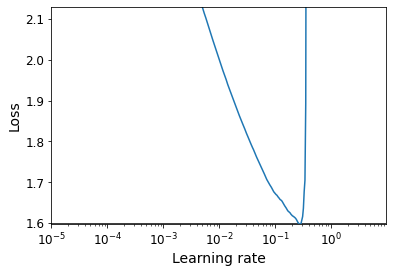

In [78]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [79]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [80]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 4s 9ms/step - loss: 0.6572 - accuracy: 0.7739 - val_loss: 0.4872 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.4581 - accuracy: 0.8396 - val_loss: 0.4275 - val_accuracy: 0.8522
Epoch 3/25
430/430 [==============================] - 4s 8ms/step - loss: 0.4122 - accuracy: 0.8547 - val_loss: 0.4114 - val_accuracy: 0.8584
Epoch 4/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3837 - accuracy: 0.8643 - val_loss: 0.3870 - val_accuracy: 0.8684
Epoch 5/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3640 - accuracy: 0.8718 - val_loss: 0.3765 - val_accuracy: 0.8684
Epoch 6/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3457 - accuracy: 0.8775 - val_loss: 0.3746 - val_accuracy: 0.8710
Epoch 7/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3330 - accuracy: 0.8812 - val_loss: 0.3636 - val_accuracy: 0.8716
Epoch 

**Avoiding Overfitting Through Regularization**

**$\ell_1$ and $\ell_2$ regularization**

In [81]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor of 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [82]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 17s 9ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 16s 9ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [83]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 18s 10ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 16s 9ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


**Dropout**

In [84]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5838 - accuracy: 0.7997 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4209 - accuracy: 0.8443 - val_loss: 0.3396 - val_accuracy: 0.8714


**Alpha Dropout**

In [85]:
tf.random.set_seed(42)
np.random.seed(42)

In [86]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 11s 6ms/step - loss: 0.6617 - accuracy: 0.7611 - val_loss: 0.5777 - val_accuracy: 0.8410
Epoch 2/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5548 - accuracy: 0.7966 - val_loss: 0.5416 - val_accuracy: 0.8480
Epoch 3/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5258 - accuracy: 0.8063 - val_loss: 0.5018 - val_accuracy: 0.8570
Epoch 4/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5049 - accuracy: 0.8131 - val_loss: 0.4768 - val_accuracy: 0.8600
Epoch 5/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4926 - accuracy: 0.8179 - val_loss: 0.4620 - val_accuracy: 0.8610
Epoch 6/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4839 - accuracy: 0.8203 - val_loss: 0.4777 - val_accuracy: 0.8600
Epoch 7/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4713 - accuracy: 0.8248 - val_loss: 0.5012 - val_ac

In [87]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4725 - accuracy: 0.8588


[0.4724937081336975, 0.8587999939918518]

In [88]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 3ms/step - loss: 0.3418 - accuracy: 0.8819


[0.3418077826499939, 0.8819272518157959]

In [89]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 10s 6ms/step - loss: 0.4182 - accuracy: 0.8432


**MC Dropout**

In [90]:
tf.random.set_seed(42)
np.random.seed(42)

In [91]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

In [92]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99]],
      dtype=float32)

In [93]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.38, 0.  , 0.2 , 0.  , 0.42]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.26, 0.  , 0.53]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.21, 0.  , 0.73]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.19, 0.  , 0.7 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.24, 0.  , 0.11, 0.  , 0.65]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.14, 0.  , 0.48, 0.  , 0.38]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.99]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.98, 0.  , 0.02, 0.  , 0.01]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.9 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.19, 0.  , 0.79]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.  , 0.07, 0.  , 0.88]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.75, 0.  , 0.05, 0.  , 0.2 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.01, 0.  , 0.89]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.29, 0.  , 0.14, 0.  , 0

In [94]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.24, 0.  , 0.59]],
      dtype=float32)

In [95]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.23, 0.  , 0.23, 0.  , 0.29]],
      dtype=float32)

In [96]:
y_pred = np.argmax(y_proba, axis=1)

In [97]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8717

In [98]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [99]:
tf.random.set_seed(42)
np.random.seed(42)

In [100]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [101]:
mc_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_249 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_250 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [102]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [103]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [104]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  , 0.28, 0.  , 0.57]],
      dtype=float32)

**Max norm**

In [105]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [106]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 17s 9ms/step - loss: 0.4741 - accuracy: 0.8337 - val_loss: 0.3711 - val_accuracy: 0.8638
Epoch 2/2
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3566 - accuracy: 0.8711 - val_loss: 0.3563 - val_accuracy: 0.8740
